In [1]:
from IPython.display import Markdown

In this notebook I study the paper 

Weingartner J. C. & Draine B. T., 2001, ApJ, 548, 296. 
https://ui.adsabs.harvard.edu/abs/2001ApJ...548..296W/abstract
[WD01]

with the objective of reproducing its grain size distribution.

I (Eda Gjergo, <GalacticCEM@gmail.com>) wrote the original routine in 2017 as part of my PhD work.
In the final plot I consider the limit of 0.03 microns proposed in 
Hirashita (2015)
https://ui.adsabs.harvard.edu/abs/2015MNRAS.447.2937H/abstract

To separate the small and large grain population for

    * carbonaceous dust
    * silicate dust
    * total dust
    
I compute the mass ratio between small and large grains for the 3 categories, as well as a carbon to silicate & carbon to total ratio. I employed these theoretical values to investigate the ratios I obtained in my simulations 
(Gjergo et al., 2018)
https://ui.adsabs.harvard.edu/abs/2018MNRAS.479.2588G/abstract

Apologies for the ugly code, this was a study companion to [WD01]

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scispe
import scipy.integrate as sciint

plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.linewidth'] = 2


''' Set up the variables '''
# From Table 1, 4th row ("model 4")
RV = 3.1
tentothe5bC = 3. # fit for microwave emission
alphag = -1.91
betag = -0.125
atg = 0.00837
acg = 0.499
Cg = 4.15e-11
alphas = -1.41
betas = -11.5
ats = 0.171 #microns
acs = 0.1
Cs = 1.33e-12
Vtildeg = 1.119
Vtildes = 1.260
Chi12 = 0.049
Chi22 = 0.139
Chi2 = 0.119

nH =  1 
mC =  1.99e-23  # Mass of 1 Carbon atom
rho =  2.24   # [g cm**-3]
bc =  tentothe5bC * 1e-5 # Carbon abundance per H nucleus
bc1 =  0.75 * bc
bc2 =  0.25 * bc
a01 =  .00035 # microns
a02 =  .003  # microns
sigma =  0.4

# Eq. (3)
B1 = 3 / (2 * np.pi) ** (1.5) * np.exp(-4.5 * sigma**2) / (rho * 1e-12 * a01**3 * sigma) * bc1 * mC / (1 + scispe.erf(3* sigma/ np.sqrt(2) + np.log(a01/.00035)/(sigma * np.sqrt(2))))
B2 = 3 / (2 * np.pi) ** (1.5) * np.exp(-4.5 * sigma**2) / (rho * 1e-12 * a02**3 * sigma) * bc2 * mC / (1 + scispe.erf(3* sigma/ np.sqrt(2) + np.log(a02/.00035)/(sigma * np.sqrt(2))))

In [16]:
# D function (eq. 2) a > 3.5 Angstroms
def Dafunc(a):
    Da = (B1 * np.exp(-0.5 * (np.log(a / a01) / sigma) ** 2) + B2 * np.exp(-0.5 * (np.log(a / a02) / sigma) ** 2)) / a; # for a > 3.5 Angstroms
    return Da

# F functions (eq. 6)
#function Fgbetal = Fgfuncbetal(a) # beta >= 0 
#  Fgbetal = 1 + betag * a / atg
#  end
#Fgbetal = @Fgfuncbetal

#function Fsbetal = Fsfuncbetal(a) # beta >= 0
#  Fsbetal = 1 + betas * a / ats
#  end
#Fsbetal = @Fsfuncbetal

def Fgfuncbetas(a): # beta < 0
    Fgbetas = (1 - betag * a /atg)**(-1)
    return Fgbetas

def Fsfuncbetas(a): # beta < 0
    Fsbetas = (1 - betas * a /ats)**(-1)
    return Fsbetas

# ngr is the number density of grains with size 3.5 Angstroms < a < atg
def dgabund(a):
    dngr = (Dafunc(a) + Cg / a * (a / atg)**alphag * Fgfuncbetas(a))
    return dngr

# a > atg 
def dgabunds(a):
    dngrsmall = ((Dafunc(a) + Cg / a * (a / atg)**alphag * Fgfuncbetas(a)) * np.exp(-((a - atg)/ acg)**3))
    return dngrsmall

def dsabund(a):
    dngrs = (Cs / a * (a / ats)**alphas * Fsfuncbetas(a))
    return dngrs

# a > atg 
def dsabunds(a):
    dnsrsmall = (Cs / a * (a / ats)**alphas * Fsfuncbetas(a) * np.exp(-((a - ats)/ acs)**3))
    return dnsrsmall

def dgabundint(a):
    dngr = a**3 * (Dafunc(a) + Cg / a * (a / atg)**alphag * Fgfuncbetas(a))
    return dngr

# a > atg 
def dgabundsint(a):
    dngrsmall = a**3 * ((Dafunc(a) + Cg / a * (a / atg)**alphag * Fgfuncbetas(a)) * np.exp(-((a - atg)/ acg)**3))
    return dngrsmall

def dsabundint(a):
    dngrs = a**3 * (Cs / a * (a / ats)**alphas * Fsfuncbetas(a))
    return dngrs

# a > atg 
def dsabundsint(a):
    dnsrsmall = a**3 * (Cs / a * (a / ats)**alphas * Fsfuncbetas(a) * np.exp(-((a - ats)/ acs)**3))
    return dnsrsmall

In [17]:
Ygs = np.linspace(.0005,atg,num=100)
ags = np.linspace(.0005,atg,num=100)
for i in range(len(Ygs)):
    Ygs[i] = dgabund(ags[i])
Ygs = np.multiply(Ygs, np.power(ags,4))

Yss = np.linspace(.0005,ats,num=100)
ass = np.linspace(.0005,ats,num=100)
for i in range(len(Yss)):
    Yss[i] = dsabund(ass[i])
Yss = np.multiply(Yss, np.power(ass,4))

Ygl = np.linspace(atg,1,num=100)
agl = np.linspace(atg,1,num=100)
for i in range(len(Ygl)):
    Ygl[i] = dgabunds(agl[i])
Ygl = np.multiply(Ygl, np.power(agl,4))

Ysl = np.linspace(ats,1,num=100)
asl = np.linspace(ats,1,num=100)
for i in range(len(Ysl)):
    Ysl[i] = dsabunds(asl[i])
Ysl = np.multiply(Ysl, np.power(asl,4))

aH15 = 0.03
smallCgrains = sciint.quad(dgabundint, a01, atg) + sciint.quad(dgabundsint, atg, aH15)
print('smallCgrains ', smallCgrains)
largeCgrains = sciint.quad(dgabundsint, aH15, 1)
print('largeCgrains ', largeCgrains)
smallSilgrains = sciint.quad(dsabundint, a01, ats) + sciint.quad(dsabundsint, ats, aH15)
print('smallSilgrains ', smallSilgrains)
largeSilgrains = sciint.quad(dsabundsint, aH15, 1)
print('largeSilgrains ', largeSilgrains)
soverl = (smallCgrains[0] + smallSilgrains[0]) / (largeCgrains[0] + largeSilgrains[0])
CsoverCl = (smallCgrains[0]) / (largeCgrains[0])
SilsoverSill = (smallSilgrains[0]) / (largeSilgrains[0])
CoverSil = (smallCgrains[0] + largeCgrains[0]) / (smallSilgrains[0] + largeSilgrains[0])
CoverTot = (smallCgrains[0] + largeCgrains[0]) / (smallSilgrains[0] + largeSilgrains[0] + smallCgrains[0] + largeCgrains[0])
print('abund grains ratio S/L:   ', soverl)
print('abund grains ratio C/Sil: ', CoverSil)
print('mass ratio C vs tot:      ', CoverTot)

smallCgrains  (8.253948469880365e-17, 2.907448897460288e-20, 5.3943053615067776e-17, 2.7574022809941413e-26)
largeCgrains  (4.106486105672058e-16, 1.1231715406500614e-19)
smallSilgrains  (6.518296561900357e-16, 3.619457154108168e-17, -1.7329483059540645e-15, 4.72690414159845e-23)
largeSilgrains  (1.9886340784075724e-15, 4.3723565420957476e-18)
abund grains ratio S/L:    0.30607862269145025
abund grains ratio C/Sil:  0.18678086307486008
mass ratio C vs tot:       0.1573844581475007


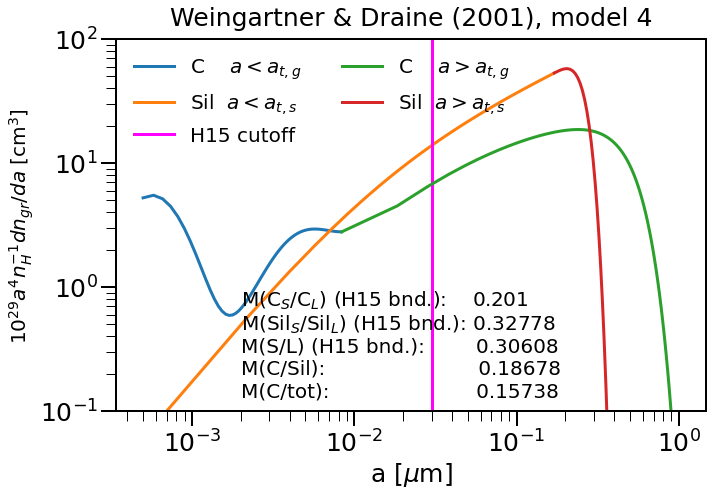

<Figure size 432x288 with 0 Axes>

In [18]:
# 1e29 times 1e4 and 1e-16 to switch microns to cm
fig = plt.figure(figsize = (10,7))
plt.loglog(ags, 1e17 * Ygs, linewidth = 3, label = r'C    $a < a_{t,g}$')
plt.loglog(ass, 1e17 * Yss, linewidth = 3, label = r'Sil  $a < a_{t,s}$')
plt.axvline(x = aH15, linewidth = 3, color = 'magenta', label = 'H15 cutoff')
plt.loglog(agl, 1e17 * Ygl, linewidth = 3, label = r'C    $a > a_{t,g}$')
plt.loglog(asl, 1e17 * Ysl, linewidth = 3, label = r'Sil  $a > a_{t,s}$')
plt.ylim(1e-1,1e2)
plt.text(0.002,0.7,  r'M(C$_S$/C$_L$) (H15 bnd.):    ' + str(np.around(CsoverCl, decimals = 5)), fontsize = 20)
plt.text(0.002,0.45, r'M(Sil$_S$/Sil$_L$) (H15 bnd.): ' + str(np.around(SilsoverSill, decimals = 5)), fontsize = 20)
plt.text(0.002,0.3,   'M(S/L) (H15 bnd.):        ' + str(np.around(soverl, decimals = 5)), fontsize = 20)
plt.text(0.002,0.2,   'M(C/Sil):                        ' + str(np.around(CoverSil, decimals = 5)), fontsize = 20)
plt.text(0.002,0.13,  'M(C/tot):                       ' + str(np.around(CoverTot, decimals = 5)), fontsize = 20)
plt.ylabel(r'$10^{29}a^4n_H^{-1}dn_{gr}/da$ [cm$^3$]', fontsize = 20)
plt.xlabel(r'a [$\mu$m]', fontsize = 25)
plt.title('Weingartner & Draine (2001), model 4', fontsize= 25, y = 1.02)
plt.legend(ncol = 2, loc = 'upper left', fontsize = 20, frameon = False)
plt.tight_layout()
plt.show(block=False)
plt.savefig('Weingartner+Draine01_model4.pdf')